In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 导入环境

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from model import CalliGAN, CalliGANGenerator, CalliGANDataset

%matplotlib inline

print(tf.__version__)
print(tfa.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Keras version", tf.keras.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

2.9.0
0.17.1
Eager mode:  True
Keras version 2.9.0
GPU is available


# 回调

In [4]:
class LearnRateDecayScheduler(tf.keras.callbacks.Callback):
    
    def __init(self):
        super(LearnRateDecayScheduler, self).__init__()
        
    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.d_optimizer, "lr") or not hasattr(self.model.g_optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = float(tf.keras.backend.get_value(self.model.d_optimizer.learning_rate))
        if (epoch+1) % 10 == 0:
            lr = lr / 2.0
            lr = max(lr, 0.0002)
        tf.keras.backend.set_value(self.model.d_optimizer.lr, lr)
        tf.keras.backend.set_value(self.model.g_optimizer.lr, lr)

        
class TerminateOnNaN(tf.keras.callbacks.Callback):

    def __init__(self):
        super().__init__()
        self._supports_tf_logs = True

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get("g_loss")
        if loss is not None:
            if np.isnan(loss) or np.isinf(loss):
                self.model.stop_training = True

        
class ModelSaveCheckpoint(tf.keras.callbacks.Callback):

    def __init__(self, freq=1, directory='checkpoints', **kwargs):
        super(ModelSaveCheckpoint, self).__init__()
        assert freq > 0
        self.freq = freq
        self.directory = directory
    
    def on_epoch_end(self, epoch, logs=None):
        os.makedirs(Path(os.getcwd(), self.directory), exist_ok=True)
        if (epoch+1) % self.freq == 0:
            self.model.generator.save_weights(Path(self.directory, f"CalliGAN_generator_{epoch+1}.h5"))
            self.model.discriminator.save_weights(Path(self.directory, f"CalliGAN_discriminator_{epoch+1}.h5"))

# 帮助函数

In [5]:
def drawing_train_history(model_name, g_loss, d_loss):
    plt.figure(figsize=(10, 16))
    plt.rcParams['figure.figsize'] = [16, 9]
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 2)
    plt.plot(g_loss, label='Generator Loss')
    plt.plot(d_loss, label='Discriminator Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'{model_name}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)

# 训练

In [6]:
batch_size = 6
epochs = 100
initial_epoch = 92

train_image_dir = 'datasets-with-paper/images/train'
components_path = 'datasets-with-paper/components/hanzi2components.txt'

## 使用 keras.Squeence 加载数据

In [7]:
train_gen = CalliGANGenerator(batch_size=batch_size,
                          images_path=train_image_dir,
                          components_path=components_path, 
                            augment=True)

47641 images found in datasets-with-paper/images/train


## 编译模型

In [11]:
model = CalliGAN()
model.compile(
              g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5, beta_2=0.999), 
              d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5, beta_2=0.999), 
              pixel_wise_loss_fn=tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.AUTO), 
              constancy_loss_fn=tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.AUTO), 
              category_loss_fn=tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.AUTO),
#               adversarial_loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.AUTO) # Standard GAN loss
              adversarial_loss_fn=tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.AUTO) # LSGAN loss
              )
if os.path.exists('CalliGAN_generator.h5'):
    discard = model.generator([tf.zeros([1, 28]), tf.zeros([1, 256, 256, 1]), tf.zeros([1, 7])])
    model.generator.load_weights('CalliGAN_generator.h5')
if os.path.exists('CalliGAN_discriminator.h5'):
    discard = model.discriminator(tf.zeros([1, 256, 256, 2]))
    model.discriminator.load_weights('CalliGAN_discriminator.h5')

In [12]:
history = model.fit(train_gen, 
                    epochs=epochs,
                    initial_epoch=initial_epoch,
                    callbacks=[
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='g_loss', factor=0.90, patience=3, mode='min'),
                        tf.keras.callbacks.EarlyStopping(monitor='g_loss', patience=5, restore_best_weights=True, mode='min'),
                        ModelSaveCheckpoint(),
                        TerminateOnNaN()
                  ])

Epoch 93/100
4442/7940 [===============>..............] - ETA: 2:49:30 - g_loss: 12.6833 - d_loss: 0.0175

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7940/7940 [==============================] - 23132s 3s/step - g_loss: 12.7430 - d_loss: 0.0175 - lr: 0.0010
Epoch 94/100
2029/7940 [======>.......................] - ETA: 4:47:03 - g_loss: 12.6164 - d_loss: 0.0137

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7842/7940 [============================>.] - ETA: 4:45 - g_loss: 12.7467 - d_loss: 0.0164

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5927/7940 [=====================>........] - ETA: 1:37:48 - g_loss: 12.6585 - d_loss: 0.0147

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4075/7940 [==============>...............] - ETA: 3:07:22 - g_loss: 12.6284 - d_loss: 0.0160

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3205/7940 [===========>..................] - ETA: 3:49:07 - g_loss: 12.5084 - d_loss: 0.0134

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7940/7940 [==============================] - 23067s 3s/step - g_loss: 12.6792 - d_loss: 0.0160 - lr: 0.0010
Epoch 98/100
1537/7940 [====>.........................] - ETA: 5:09:34 - g_loss: 12.5182 - d_loss: 0.0123

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7940/7940 [==============================] - 23030s 3s/step - g_loss: 12.6605 - d_loss: 0.0153 - lr: 0.0010
Epoch 99/100
2290/7940 [=======>......................] - ETA: 4:34:14 - g_loss: 12.4917 - d_loss: 0.0136

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7940/7940 [==============================] - 23117s 3s/step - g_loss: 12.6424 - d_loss: 0.0149 - lr: 0.0010
Epoch 100/100
3269/7940 [===========>..................] - ETA: 3:47:24 - g_loss: 12.5020 - d_loss: 0.0146

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7940/7940 [==============================] - 23069s 3s/step - g_loss: 12.6627 - d_loss: 0.0151 - lr: 0.0010


## 绘制训练日志

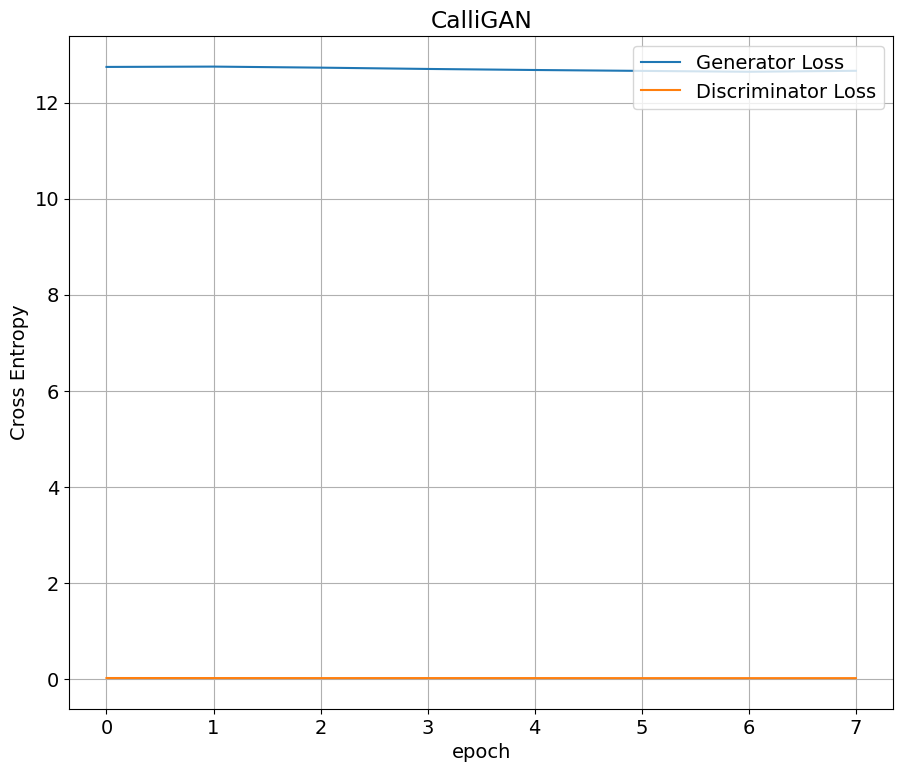

In [13]:
g_loss = history.history['g_loss']
d_loss = history.history['d_loss']
drawing_train_history('CalliGAN', g_loss, d_loss)

## 保存模型

In [14]:
model.generator.save_weights("CalliGAN_generator.h5")
model.discriminator.save_weights("CalliGAN_discriminator.h5")